In [4]:
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from tqdm import tqdm
from functools import reduce
from itertools import product
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

load_dotenv()

True

In [5]:
dfs = [pl.read_csv(file) for file in Path(os.getenv('RAW_DATA_DIR')).glob(r'*[0-9].csv')]
len(dfs)

KeyboardInterrupt: 

In [36]:
all_names = pl.concat([df.select('title') for df in dfs]).unique()
print(f'{len(all_names):,}')

1,976,658


In [34]:
transformed_dfs = []
for df in tqdm(dfs):
    transformed_df = (df.with_columns(pl.col('month')
                                    .map_elements(lambda s: f'{s[:4]}-{s[5:7]}')
                                    .alias('year_month'))
                      .pivot(index='title', columns='year_month', values='monthly_views')
    )
    transformed_dfs.append(transformed_df)

100%|██████████| 9/9 [02:05<00:00, 13.89s/it]


In [41]:
views_df = all_names
for i, df in tqdm(enumerate(transformed_dfs)):
    views_df = df.join(views_df, 'title', 'outer_coalesce')
views_df = views_df.select(['title', *sorted([c for c in views_df.columns if c != 'title'])])
views_df

9it [00:05,  1.51it/s]


title,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,…,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Neophyte_II_of…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,14,17,26,10,17,24,29,32,51,20,36,46,32,119,27,32,18,26,22,30,30,26,35,33,33,26,25,24,29,44,23,25
"""Olivia_Giovett…",26,34,52,20,41,40,19,21,27,23,32,21,32,29,57,47,31,21,24,15,42,17,45,30,25,34,36,22,22,22,16,28,30,34,22,19,…,39,30,32,34,37,29,14,26,24,36,39,35,20,63,33,39,19,19,30,20,14,21,35,52,25,25,33,20,18,22,31,26,16,20,59,41,19
"""Alexander_Gran…",9,48,24,23,32,24,12,20,19,7,8,14,18,27,11,23,12,19,15,17,11,13,26,14,16,18,13,20,13,26,16,19,32,14,18,12,…,5,13,9,12,11,9,14,19,9,7,5,11,4,11,9,7,9,9,4,5,12,72,6,10,10,10,2,7,10,7,2,7,4,9,10,1,5
"""Bernard_H._Rae…",17,16,21,20,19,18,10,9,17,5,8,10,5,28,19,11,17,14,13,19,16,13,24,18,10,10,14,13,14,19,5,15,26,12,13,10,…,2,1,4,1,5,5,3,5,2,2,3,4,null,12,4,3,2,1,4,null,1,3,8,6,3,1,5,1,3,5,7,3,1,2,null,1,2
"""Leigh_Magar""",47,46,64,36,56,45,41,26,30,48,15,26,19,38,28,38,37,51,24,36,17,15,45,39,26,22,21,14,19,23,16,32,36,21,18,20,…,8,8,9,13,6,3,12,13,12,5,8,8,11,3,9,8,13,13,9,20,9,8,14,27,14,13,20,13,10,9,5,9,9,8,5,10,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Edgar_Dibden""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,16,6,10,6,7,4,2
"""David_Mulready…",56,51,78,51,54,59,36,44,31,33,29,29,29,54,44,45,23,36,38,35,32,31,42,27,44,33,27,52,29,41,21,36,47,64,37,30,…,16,21,27,33,15,22,31,15,25,16,25,12,25,27,31,18,27,25,20,21,34,15,16,14,15,19,26,19,18,12,7,19,12,14,14,7,6
"""Bruno_Riem""",40,29,34,17,31,29,22,31,14,8,8,16,13,16,7,17,24,16,20,14,14,7,23,16,25,14,13,15,13,20,10,17,31,14,13,12,…,4,9,2,4,5,4,7,8,6,7,8,5,5,4,4,7,2,5,4,11,2,4,5,5,3,5,2,2,4,3,7,5,4,3,3,1,2


In [43]:
views_df.write_parquet('../data/pageviews_all.parquet')

In [61]:
from typing import Iterable

In [86]:
def plot_views_by_names(names: Iterable):
    plt.figure(figsize=(20, 3))
    for name in names:
        try:
            x = views_df.select(pl.exclude('title')).columns
            y = views_df.filter(pl.col('title') == name).select(pl.exclude('title')).to_numpy().ravel()
            plt.plot(x, y, label=name)
        except:
            print(f'{name} not found.')
            continue
    plt.legend()
    plt.xticks(rotation=-90)
    plt.show();

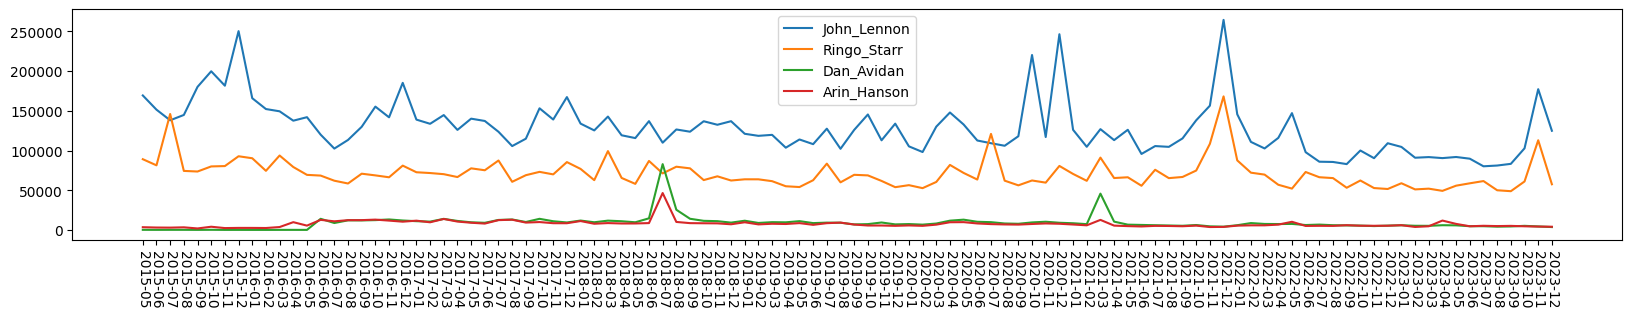

In [87]:
plot_views_by_names(['John_Lennon', 'Ringo_Starr', 'Dan_Avidan', 'Arin_Hanson'])